## Current Research in Data Science: Feature Selection

In [1]:
import os
import copy
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np, random
import time
import seaborn as sns
from sklearn import datasets, svm, metrics, linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, VarianceThreshold, RFE, f_classif, mutual_info_classif 
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

random_state = 1337

### 0. Data Preparation and Preprocessing

For demonstrating the use of feature selection in Data Science and Machine Learning, we chose a dataset from the OpenML platform named credit-g:
https://www.openml.org/d/31

This classification dataset contains 21 variables (continuous and categorical), which are well understandable and explainable. Therefore, it serves as a good basis for understanding and getting to know the process of feature selection in general. 

In [2]:
def load_df_from_dir(folder_path = '', file_path = "dataset_31_credit-g.csv"):
    df = pd.read_csv(os.path.join(folder_path, file_path))
    return df

In [3]:
def preprocess_df(df, rand_col_num=50, rand_col_cat=50):
    X = df.loc[:, df.columns != 'class']
    y = df.loc[:, df.columns == 'class']

    # convert target to 0/1 variable
    y = y.eq('good').mul(1)

    # convert categorical features to dummy variables
    cat_vars = [key for key in dict(X.dtypes)
                if dict(X.dtypes)[key] in ['object']]

    for var in cat_vars:
        cat_list = 'var' + '_' + var
        cat_list = pd.get_dummies(X[var], prefix=var)
        X1 = X.join(cat_list)
        X = X1

    X_vars = X.columns.values.tolist()
    to_keep = [i for i in X_vars if i not in cat_vars]
    X = X[to_keep]

    # optional: add useless columns to dataframe (categorical and numeric)
    if rand_col_cat != 0 or rand_col_num != 0:
        np.random.seed(1234)
        for i in range(rand_col_num + 1):
            X['rand_col_num_' + str(i)] = np.random.randn(len(X)) + 50

        for j in range(rand_col_cat + 1):
            X['rand_col_cat_' + str(j)] = np.random.choice(a=[0, 1], size=len(X))

    return X, y

In [4]:
# load and preprocess credit data
df = load_df_from_dir()
df.head(10)

checking_status  duration                    credit_history  \
0            '<0'         6  'critical/other existing credit'   
1      '0<=X<200'        48                   'existing paid'   
2   'no checking'        12  'critical/other existing credit'   
3            '<0'        42                   'existing paid'   
4            '<0'        24              'delayed previously'   
5   'no checking'        36                   'existing paid'   
6   'no checking'        24                   'existing paid'   
7      '0<=X<200'        36                   'existing paid'   
8   'no checking'        12                   'existing paid'   
9      '0<=X<200'        30  'critical/other existing credit'   

               purpose  credit_amount      savings_status  employment  \
0             radio/tv           1169  'no known savings'       '>=7'   
1             radio/tv           5951              '<100'    '1<=X<4'   
2            education           2096              '<100'    '4<=X<7'   
3  furniture/equipment           7882              '<100'    '4<=X<7'   
4            'new car'           4870              '<100'    '1<=X<4'   
5            education           9055  'no known savings'    '1<=X<4'   
6  furniture/equipment           2835       '500<=X<1000'       '>=7'   
7           'used car'           6948              '<100'    '1<=X<4'   
8             radio/tv           3059            '>=1000'    '4<=X<7'   
9            'new car'           5234              '<100'  unemployed   

   installment_commitment       personal_status other_parties  ...  \
0                       4         'male single'          none  ...   
1                       2  'female div/dep/mar'          none  ...   
2                       2         'male single'          none  ...   
3                       2         'male single'     guarantor  ...   
4                       3         'male single'          none  ...   
5                       2         'male single'          none  ...   
6                       3         'male single'          none  ...   
7                       2         'male single'          none  ...   
8                       2        'male div/sep'          none  ...   
9                       4        'male mar/wid'          none  ...   

    property_magnitude age  other_payment_plans     housing existing_credits  \
0        'real estate'  67                 none         own                2   
1        'real estate'  22                 none         own                1   
2        'real estate'  49                 none         own                1   
3     'life insurance'  45                 none  'for free'                1   
4  'no known property'  53                 none  'for free'                2   
5  'no known property'  35                 none  'for free'                1   
6     'life insurance'  53                 none         own                1   
7                  car  35                 none        rent                1   
8        'real estate'  61                 none         own                1   
9                  car  28                 none         own                2   

                           job num_dependents  own_telephone foreign_worker  \
0                      skilled              1            yes            yes   
1                      skilled              1           none            yes   
2         'unskilled resident'              2           none            yes   
3                      skilled              2           none            yes   
4                      skilled              2           none            yes   
5         'unskilled resident'              2            yes            yes   
6                      skilled              1           none            yes   
7  'high qualif/self emp/mgmt'              1            yes            yes   
8         'unskilled resident'              1           none            yes   
9  'high qualif/self emp/mgmt'          

In [5]:
X, y = preprocess_df(df, 50, 50)
print(X.shape)
print(y.shape)

(1000, 163)
(1000, 1)


### 1. Usage of Filters

Filters are also known as **univariate feature selection** and are applied to the dataset independently from the chosen model. 
They simply choose a subset of features (of fixed size) based on a given criterium and can therefore be interpreted as a preprocessing step. 

We demonstrate the functionality of the following different filters on the `credit-g` dataset:
* variance threshold
* f1 score
* mutual information
* chi2
* tree based: make use of the feature importance delivered by tree based models

Note: The choice of the scoring function has to be suitable for the target variable (classification or regression task). In this case, the target is binary.

In [6]:
list_of_filters = [
    {
         'name': 'variance',
         'object': VarianceThreshold(threshold = 2),
    },
    {
         'name': 'f_score',
         'object': SelectKBest(f_classif, k = 10)
    }, 
    {
         'name': 'mutual_info',
         'object': SelectKBest(mutual_info_classif, k = 10)
    }, 
    {
         'name': 'chi2',
         'object': SelectKBest(chi2, k = 10)
    },
    {
        'name': 'tree_based',
        'object': SelectFromModel(ExtraTreesClassifier(n_estimators = 5, random_state = 1337), prefit = False, threshold=-np.inf, max_features  =10)
    }
]

In [7]:
# Apply filters to dataset and print chosen features

features = X.columns

filter_df = pd.DataFrame(data={'feature': features})

for filter in list_of_filters:
    selector = filter['object']
    selector.fit(X,y)
    values = selector.get_support()
    values = values.astype(int)
    filter_df[filter['name']] = values
    
filter_df['count'] = filter_df.sum(axis=1) 
filter_df = filter_df.sort_values(by='count', ascending=False)
filter_df.head(30)

feature  variance  f_score  \
0                                           duration         1        1   
8                               checking_status_'<0'         0        1   
10                     checking_status_'no checking'         0        1   
1                                      credit_amount         1        1   
15              credit_history_'no credits/all paid'         0        1   
12   credit_history_'critical/other existing credit'         0        1   
11                         credit_history_'all paid'         0        1   
4                                                age         1        0   
30                 savings_status_'no known savings'         0        1   
28                             savings_status_'<100'         0        1   
27                      savings_status_'500<=X<1000'         0        0   
101                                  rand_col_num_40         0        0   
87                                   rand_col_num_26         0        0   
68                                    rand_col_num_7         0        0   
56                                       job_skilled         0        0   
80                                   rand_col_num_19         0        0   
51                                       housing_own         0        1   
123                                  rand_col_cat_11         0        0   
94                                   rand_col_num_33         0        0   
93                                   rand_col_num_32         0        0   
44            property_magnitude_'no known property'         0        0   
91                                   rand_col_num_30         0        0   
161                                  rand_col_cat_49         0        0   
112                                   rand_col_cat_0         0        0   
107                                  rand_col_num_46         0        0   
155                                  rand_col_cat_43         0        0   
108                                  rand_col_num_47         0        0   
109                                  rand_col_num_48         0        0   
110                                  rand_col_num_49         0        0   
111                                  rand_col_num_50         0        0   

     mutual_info  chi2  tree_based  count  
0              1     1           1      5  
8              1     1           1      4  
10             1     1           1      4  
1              0     1           0      3  
15             1     1           0      3  
12             0     1           1      3  
11             0     1           0      2  
4              0     1           0      2  
30             0     1           0      2  
28             0     0           1      2  
27             1     0           0      1  
101            0     0           1      1  
87             1     0           0      1  
68             0     0           1      1  
56             1     0           0      1  
80             0     0           1      1  
51             0     0           0      1  
123            1     0           0      1  
94             1     0           0      1  
93             0     0           1      1  
44             0     1           0      1  
91             1     0           0      1  
161            0     0           1      1  
112            0     0           0      0  
107            0     0           0      0  
155            0     0           0      0  
108            0     0           0      0  
109            0     0           0      0  
110            0     0           0      0  
111            0     0           0      0

To get a feeling, which features were frequently selected by the filters and how similar those filters are in terms of feature selection, we can now examine how often a feature was selected into the final dataset. 

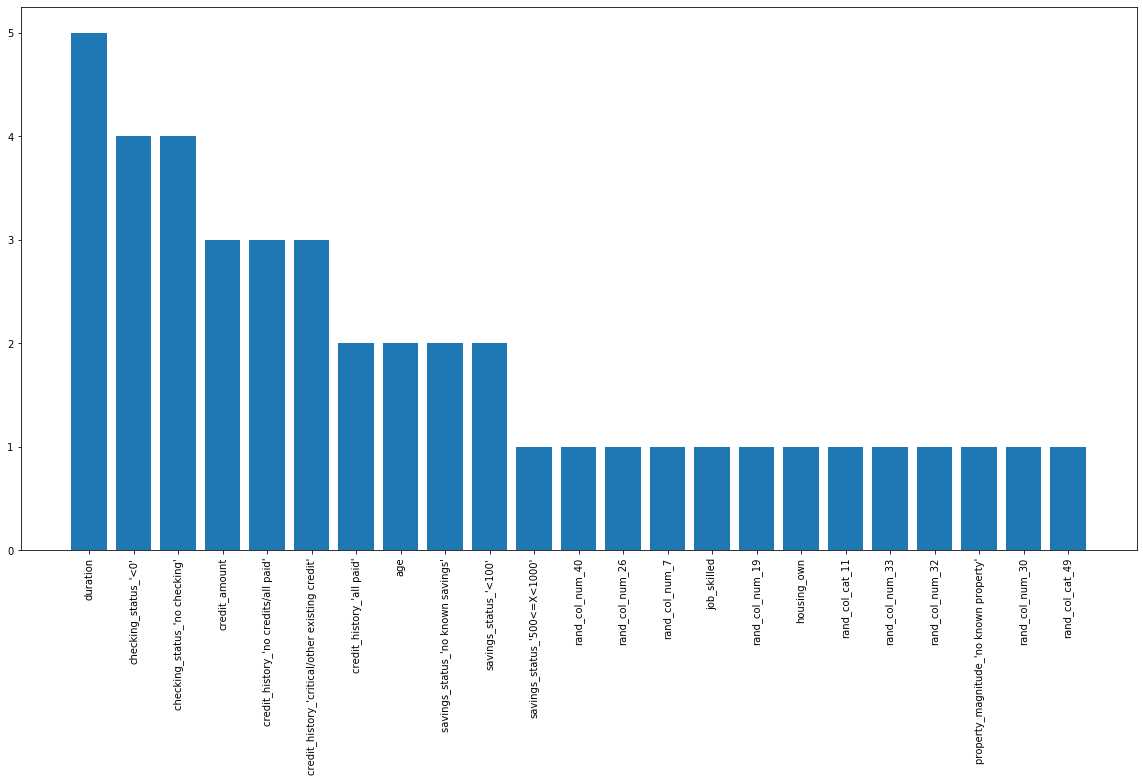

In [8]:
df_filtered = filter_df[filter_df['count']>0]

plt.rcParams['figure.figsize'] = [20, 10]
plt.bar(df_filtered['feature'], df_filtered['count'], align='center')
# plt.xticks(df_filtered['feature'])
plt.xticks(rotation=90)
plt.show()

Looking at this plot, we can conclude:
* only the variable `duration` was chosen to be relevant by all filters
* filtering with variance threshold leads to including a lot of random features 
* different filters leads different results!

Which filter to use and how many final features to choose, can be evaluated using Cross Validation. This is also incorporated in the next section.

### 2. Build and configure pipelines for feature selection
To build automated pipelines (apply several filter-methods such as RFE as wrapper method on several estimators), we rely on the pipelining integrated in scikit-learn (`sklearn.pipeline.Pipeline`). This pipelining enables a compact way of specify the learning-problem while ensuring that the during the tuning-, training- and performance-estimation-steps everything is done correctly (e.g. in case of filters, the 'filter-rule' is always applied before training only on the training data). For basic understand of the way the pipelines work in scikit-learn we refer to the documentation:
* [`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
* [`Tuning the hyper-parameters of an estimator`](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
* [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)
* [`Nested versus non-nested cross-validation`](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)
* [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [`Feature selection as part of a pipeline`](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-as-part-of-a-pipeline)
* [`mlr: Feature Selection`](https://mlr.mlr-org.com/articles/tutorial/feature_selection.html)

#### 2.1 Main functions
* some functions being called in these main functions are included below in chapter 'helper functions'
* `apply_estimator(X, y, setting)`: takes processed design-matrix X and response vector y and a setting-dictionary (including the estimator-object, potentially wrapped by a wrapper and incuding a filter-object. The inner CV (hyperparameter tuning of estimator such as hyperparameter tuning of filters and wrappers) is applied one line, while the outer CV (performance estimation) is done manually (could be done in one line as well, see below), as we have to access the tuned and trained model  to extract the complexity of it (one of the evaluation criteria)
* `compute_complexity(best_model, setting, X)`: extract complexity of the tuned model of the inner CV dependent on the best tuned model, the setting or dimensionality of design matrix. The complexity of a model depends on the estimator (e.g. regularized logistic regression: number of coefficients unequal 0, support of the best tuned model in case of filters etc.). This method has to be extended in case that this script is extended by other estimators (complexity-measure is evaluated differently for different estimators). 

In [9]:
def apply_estimator(X, y, setting):
    start_time = time.time()

    pipe, param_grid = build_pipeline_and_param_grid(setting)
    tuning = GridSearchCV(pipe, param_grid, cv=INNER_FOLDS, scoring=PERF_METRIC, error_score=0.0)

    # apply tuning and do performance-estimation (outer CV)
    # manual outer-loop to access the tuned model and its complexity, as black-box it would be:
    # cv_scores = cross_val_score(tuning, X, y, cv=outer_cv, scoring=PERF_METRIC)

    cv_scores = []
    complexities = []

    outer_cv = KFold(n_splits=OUTER_FOLDS, shuffle=False, random_state=1337)

    for train_index, test_index in outer_cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # apply tuning on train-folds
        tuning.fit(X_train, y_train)

        # get complexity from tuned model
        best_model = tuning.best_estimator_
        complexity = compute_complexity(best_model, setting, X_train)

        # performance of tuned model on test-fold = peformance estimation
        score = tuning.score(X_test, y_test)

        cv_scores.append(score)
        complexities.append(complexity)

    computed_time = np.round(time.time() - start_time, 1)

    result = build_result_object(setting, cv_scores, computed_time, complexities)

    return result


def compute_complexity(best_model, setting, X):
    # order: from general to specific

    # default: complexity = # columns of X
    complexity = X.shape[1]

    # in case of (additional) filter: complexity = support of tuned model (potentially overwritten later on)
    if 'filter' in setting.keys():
        filter_name = setting['filter']['name']
        complexity = np.sum(best_model.named_steps[filter_name].get_support())

    # in case of rf (embedded): complexity = # features where importance > threshold (+-0)
    if 'rf' == setting['estimator']['name'] and not 'wrapper' in setting['estimator'].keys():
        importances = best_model.named_steps['rf'].feature_importances_

        # important if importance e.g. is larger than 0.1 * maximum importance
        complexity = np.sum(importances > (np.max(importances) / 10.0))

    # in case of logistic regression with l1-penalty
    if 'l1_log_reg' == setting['estimator']['name'] and not 'wrapper' in setting['estimator'].keys():
        coef = best_model.named_steps['l1_log_reg'].coef_[0]
        complexity = np.sum(coef != 0)

    # in case of wrapper-setting: complexity = # features to select of tuned model
    if 'wrapper' in setting['estimator'].keys():
        estimator_name = setting['estimator']['name']
        complexity = best_model.named_steps[estimator_name].get_params()['n_features_to_select']

    return complexity

#### 2.2 Helper functions
* `build_wrapper_objects(estimator)`: using the estimator-object, create a wrapper (recursive feature elimination (RFE)) from it including the transfer of the hyperparameters from the estimator. Two wrapper objects are returned: one without hyperparameters (untuned wrapper with default-parameters) and tunable hyperparameters (such as `n_features_to_select` and `step`)  
* `build_pipeline_and_param_grid(setting)`: creates a pipeline-object with the estimator, adds filter as preprocessing-step if included in the setting and a parameter-grid of all paramters to be tuned on (filter-hyperparameter as well as estimator-hyperparameter) 
* `add_filter(pipe, setting)`: inserts filter of setting to the pipeline in front of the estimator
* `extract_filter_params(setting)`: extracts hyperparameters of filter in setting
* `extract_tuning_params(setting)`: extracts hyperparameters of estimator in setting
* `build_result_object(setting, cv_scores, computed_time, complexities)`: build result-dictionary from the setting-object such as the cv_scores (compute mean), overall computed_time and complexity (compute mean) to be added later on to result dataframe
* `extract_characteristics_from_setting(setting)`: extracts several charateristics from setting-dictionary such as name, filter, tuned_filter, wrapper, tuned_wrapper
* `plot_results_for_estimator(estimator, save=True, show=True)`: plottig the evaluation-crierias (average generalisation error, average complexity of models, overall computed time) and save and/or show plots
* `plot_overview(overview_df, save=True, show=True)`: plotting the whole picture: for all applied estimators, show the evaluated metrics (average generalisation error, average complexity of models, overall computed time) and save and/or show plot

In [10]:
def build_wrapper_objects(estimator):
    wrapper = {
        'name': estimator['name'],
        'wrapper': True,
        'object': RFE(estimator['object'], n_features_to_select=10, step=5),
        'tuning_params': {}
    }

    # append hyper-parameters from estimator
    for param_item in estimator['tuning_params'].items():
        param_name = 'estimator__' + param_item[0]
        param_values = param_item[1]

        wrapper['tuning_params'].update({param_name: param_values})

    wrapper_with_tuning = copy.deepcopy(wrapper)
    wrapper_with_tuning['tuning_params'].update(
        {
            'n_features_to_select': [3, 6, 10],
            'step': [2, 5]
        }
    )

    return wrapper, wrapper_with_tuning


def build_pipeline_and_param_grid(setting):
    estimator = setting['estimator']
    pipe = Pipeline([(estimator['name'], estimator['object'])])

    param_grid = {}

    # add regular hyper-parameter-tuning to pipeline (if requested in setting)
    if 'tuning_params' in setting['estimator'].keys():
        param_grid.update(extract_tuning_params(setting))

    # add filter to pipeline (if requested in setting)
    if 'filter' in setting.keys():
        pipe = add_filter(pipe, setting)

        # add tuning of filter-parameter to pipeline (if requested in setting)
        if 'tuning_params' in setting['filter'].keys():
            param_grid.update(extract_filter_params(setting))

    return pipe, param_grid


def add_filter(pipe, setting):
    filter = setting['filter']
    pipe.steps.insert(0, (filter['name'], filter['object']))
    return pipe


def extract_filter_params(setting):
    filter_name = setting['filter']['name']

    filter_param_grid = {}

    if 'tuning_params' in setting['filter'].keys():
        for param in setting['filter']['tuning_params'].items():
            param_name = param[0]
            param_values = param[1]

            filter_param_grid.update(
                {
                    filter_name + '__' + param_name: param_values
                }
            )

    return filter_param_grid


def extract_tuning_params(setting):
    estimator_name = setting['estimator']['name']

    tuning_param_grid = {}

    for param in setting['estimator']['tuning_params'].items():
        param_name = param[0]
        param_values = param[1]

        tuning_param_grid.update(
            {
                estimator_name + '__' + param_name: param_values
            }
        )

    return tuning_param_grid


def build_result_object(setting, cv_scores, computed_time, complexities):
    name, filter_name, tuned_filter, wrapper, tuned_wrapper = extract_characteristics_from_setting(setting)

    result = {
        'name': name,
        'filter_name': filter_name,
        'tuned_filter': tuned_filter,
        'wrapper': wrapper,
        'tuned_wrapper': tuned_wrapper,
        'avg_performance': np.mean(cv_scores),
        'computed_time': computed_time,
        'avg_complexity': np.mean(complexities)
    }

    return result


def extract_characteristics_from_setting(setting):
    name = setting['estimator']['name']
    filter_name = '-'
    tuned_filter = False
    wrapper = False
    tuned_wrapper = False

    if 'filter' in setting.keys():
        filter_name = setting['filter']['name'] if 'filter' in setting.keys() else '-'
        tuned_filter = True if 'tuning_params' in setting['filter'].keys() else False

    if 'wrapper' in setting['estimator'].keys():
        wrapper = True

        if 'n_features_to_select' in setting['estimator']['tuning_params']:
            tuned_wrapper = True

    return name, filter_name, tuned_filter, wrapper, tuned_wrapper


def plot_results_for_estimator(estimator, save=True, show=True):
    result_df = pd.read_csv('results.csv')
    
    result_df['computed_time'] = np.log(result_df['computed_time'] + 1)
    
    # filter by estimator
    filtered_results = result_df[result_df['name'] == estimator['name']]
    
    # get row of regular estimator
    regular = filtered_results[(filtered_results['filter_name'] == '-') & (-filtered_results['wrapper'])]

    # get only rows with filters and get row of best untuned and tuned filter
    filters = filtered_results[filtered_results['filter_name'] != '-']
    untuned_filters = filters[-filters['tuned_filter']]
    tuned_filters = filters[filters['tuned_filter']]
    best_untuned = untuned_filters[untuned_filters['avg_performance'] == np.max(untuned_filters['avg_performance'])]
    best_tuned = tuned_filters[tuned_filters['avg_performance'] == np.max(tuned_filters['avg_performance'])]

    # get rows of untuned and tuned wrapper
    wrapper = filtered_results[filtered_results['wrapper'] & -filtered_results['tuned_wrapper']]
    tuned_wrapper = filtered_results[filtered_results['tuned_wrapper']]

    # create final-df to do plotting
    overview_df = pd.concat([regular, best_untuned, best_tuned, wrapper, tuned_wrapper])
    groups = ['regular', 'untuned filter', 'tuned filter', 'untuned wrapper', 'tuned wrapper']

    colors = sns.color_palette("GnBu_d", len(groups))

    fig, axs = plt.subplots(3)
    fig.set_figheight(10)
    fig.set_figwidth(8)
    fig.subplots_adjust(hspace=1)
    fig.suptitle('estimator: '+estimator['name'], fontsize=16, fontweight='bold')
    axs[0].bar(x=groups, height=overview_df['avg_performance'].fillna(0), color=colors)
    axs[0].set_ylim(np.min(result_df['avg_performance'])*0.99, np.max(result_df['avg_performance'])*1.01)
    axs[0].title.set_text('CV Performance (f1-score)')
    axs[1].bar(x=groups, height=overview_df['avg_complexity'].fillna(0), color=colors)
    axs[1].set_ylim(np.min(result_df['avg_complexity'])*0.95, np.max(result_df['avg_complexity'])*1.05)
    axs[1].title.set_text('Complexity of model')
    axs[2].bar(x=groups, height=overview_df['computed_time'].fillna(0), color=colors)
    axs[2].set_ylim(np.min(result_df['computed_time'])*0.95, np.max(result_df['computed_time'])*1.05)
    axs[2].title.set_text('Runtime (training) (log-scale)')

    if save:
        plt.savefig(os.path.join('plots', estimator['name']+'.png'))
    
    if show:
        plt.show()
        
    return overview_df


def plot_overview(overview_df, save=True, show=True):
    # create grouped barplot, inspired by:
    # https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
    # feels like a lot of overhead...

    estimators = overview_df['name'].unique()
    n_estimators = len(estimators)
    subgroups = ['regular', 'untuned filter', 'tuned filter', 'untuned wrapper', 'tuned wrapper']
    n_subgroups = len(subgroups)


    fig, axs = plt.subplots(3)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('The complete picture', fontsize=16, fontweight='bold')

    bar_width = 0.15
    pos = list(range(n_estimators))  

    metrics = ['avg_performance', 'avg_complexity', 'computed_time']
    titles = ['CV Performance (f1-score)', 'Complexity of model', 'Runtime (training) (log-scale)']

    i = 0
    for metric in metrics:
        max_metric = np.max(overview_df[metric])
        min_metric = np.min(overview_df[metric])

        for j in range(5):
            filtered = overview_df[j::n_subgroups]
            values = list(filtered[metric].fillna(0))
            x = [p + j*bar_width for p in pos]
            axs[i].bar(x, values, bar_width, color=colors[j])
            axs[i].set_ylim(min_metric*0.95, max_metric*1.05)

        axs[i].legend(subgroups, loc='right')
        axs[i].set_xlim(np.min(pos)-bar_width, np.max(pos)+bar_width*n_estimators + 1)
        axs[i].set_xticks([p + 2 * bar_width for p in pos])
        axs[i].set_xticklabels(estimators)
        axs[i].title.set_text(titles[i])
        axs[i].title.set_fontsize(16)

        i += 1
        
    if save:
        plt.savefig(os.path.join('plots', 'z_overview.png'))
        
    if show:
        plt.show()

### 3. Application of automated feature selection

In the following, we want to demonstrate how our approach to automated feature selection works in practice. We work with a pipeline that can be constructed as required. To define the structure, we use lists of estimators, filters and wrappers, where we define those components individually. Using a dictionary, we can specify the name, the callable form and the hyperparameters that should be tuned. 
Using nested resampling, we are able to tune the setting for the feature selection methods and the model itself. 
We can then combine each (tuned) estimator with each feature selection method (tuned and untuned) and evaluate the performances as well as complexity of the final models and their runtime. 

#### 3.1 Estimators (each tuned)
* regular estimators    
    * `KNeighborsClassifier()`
    * `svm.SVC()`
    * `linear_model.LogisticRegression()`
* embedders
    * `RandomForestClassifier()`
    * `linear_model.LogisticRegression(penalty='l1')`

#### 3.2 Filters (each applied untuned and tuned)
* `SelectKBest(chi2)`
* `VarianceThreshold()`
* `SelectKBest(mutual_info_classif)`
* `SelectKBest(f_classif)`
* `SelectFromModel(ExtraTreesClassifier)`

#### 3.3 Wrappers (untuned and tuned)
* [`RFE(estimator)`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)

For more details (which hyperparameters are tuned etc.) make sure to check the file `estimators_and_filters.py` and `build_wrapper_objects(estimator)` in section '2.2 Helper functions'

In [ ]:
from estimators_and_filters import estimators, filters

# define global setting
PERF_METRIC = 'f1'
OUTER_FOLDS = 5
INNER_FOLDS = 3

# preprocess df and convert X and y to numpy-arrays
X, y = preprocess_df(df)
X = X.to_numpy()
y = y.to_numpy()

# initialise result-dataframe with columns of interest
result_df = pd.DataFrame(columns=['name', 'filter_name', 'tuned_filter', 'wrapper', 'tuned_wrapper', 'avg_performance',
                                  'computed_time', 'avg_complexity'])

for estimator in estimators:
    print('estimator: ' + estimator['name'])
    
    # run the estimator without filtering / wrapping
    setting = {'estimator': estimator}
    res = apply_estimator(X, y, setting)
    result_df = result_df.append(res, ignore_index=True)

    # apply all (tunable and untunable) filters
    for filter in filters:
        print('filter: ' + filter['name'])
        
        setting = {
            'estimator': estimator,
            'filter': filter
        }

        res = apply_estimator(X, y, setting)
        result_df = result_df.append(res, ignore_index=True)

    # apply wrapper (RFE) on estimator
    wrapper, wrapper_with_tuning = build_wrapper_objects(estimator)

    for wrapper_obj in [wrapper, wrapper_with_tuning]:
        setting = {'estimator': wrapper_obj}

        # try only as wrapper may not be applicable on estimator (i.e. no coef_ or feature_importance_ returned by estimator)
        try:
            print('applying wrapper')
            res = apply_estimator(X, y, setting)

        except RuntimeError as e:
            print('Wrapper cant be applied on this estimator (' + estimator['name'] + '):')
            print(e)

            # still append row to result-dataframe
            res = build_result_object(setting, cv_scores=[], computed_time=float('NaN'), complexities=[])

        finally:
            result_df = result_df.append(res, ignore_index=True)

print(result_df)
result_df.to_csv('results.csv')

#### 3.4 Evaluation of results

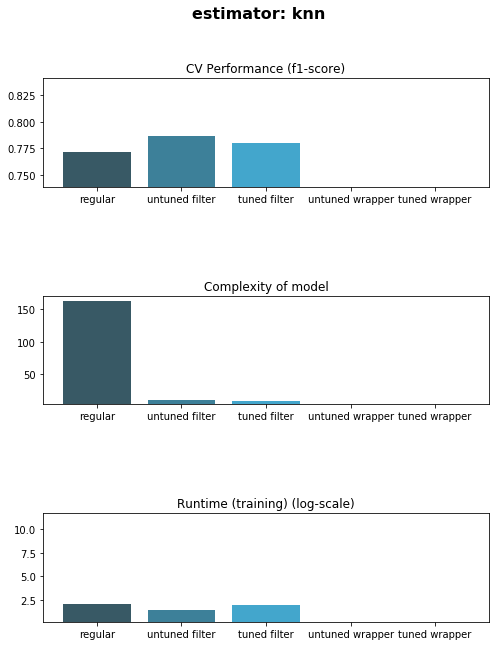

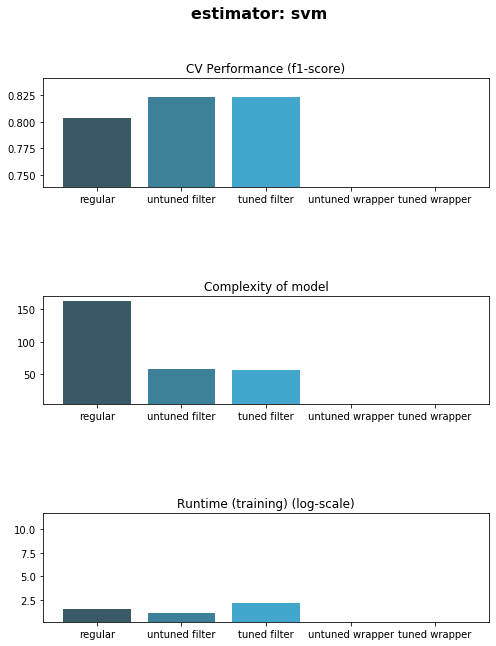

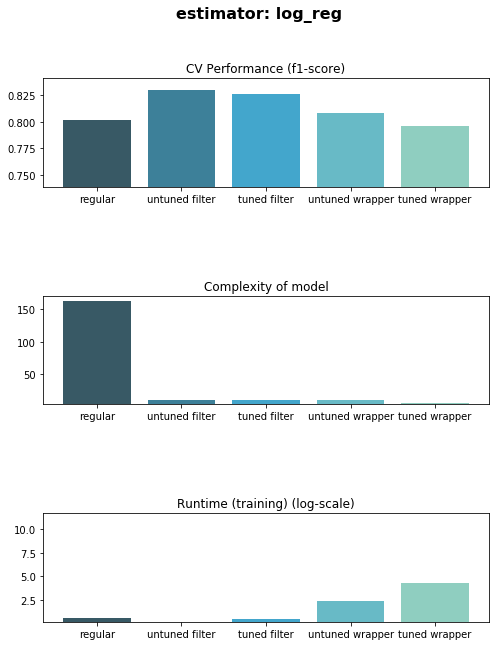

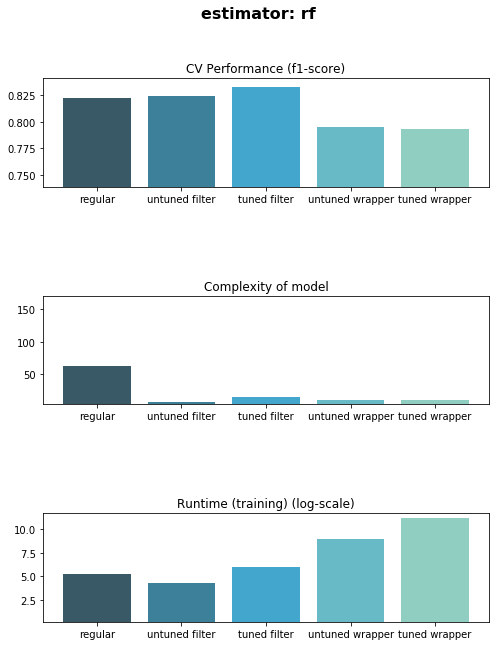

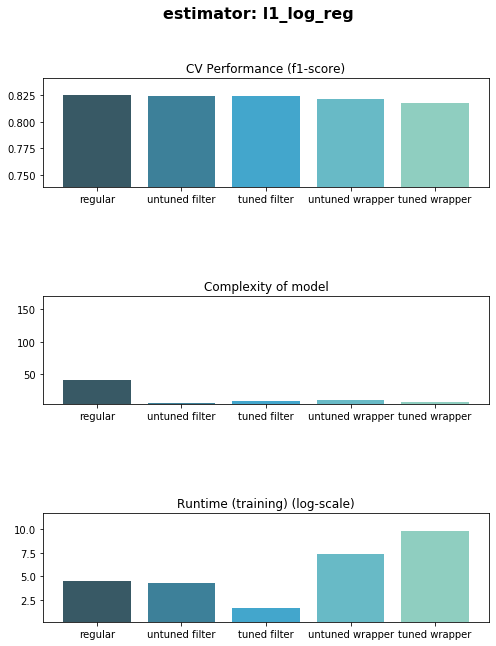

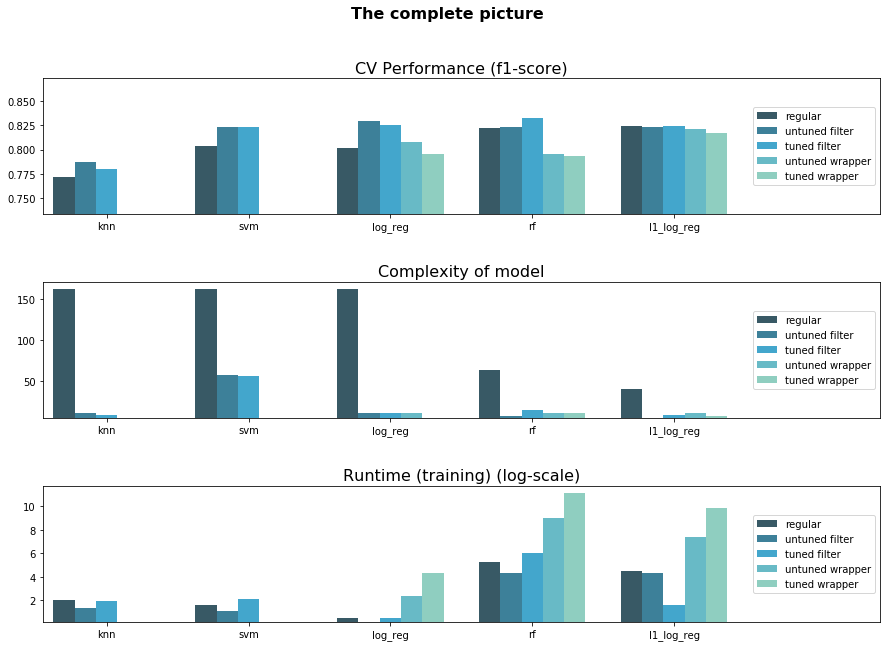

In [12]:
from estimators_and_filters import estimators, filters

# plot results
overview_df = pd.DataFrame()
colors = sns.color_palette("GnBu_d", 5)

for estimator in estimators:
    estimator_df = plot_results_for_estimator(estimator, save=True, show=True)
    overview_df = overview_df.append(estimator_df)
    
plot_overview(overview_df, save=True, show=True)

To interpret the results, performance, complexity and runtime should be considered for each estimator. 
* We observe that the embedders (i.e. penalised logistic regression and random forest) have a solid performance even without applying filtering and wrapping (as they embedd the feature selection during training). 
* The performance of all methods (also the embedders) benefits from filtering the features first. Thereby, tuning those filters does not make much difference. 
* In contrast to the filters, the wrapper method did not perform well (even in a tuned version).
* Regular estimators benefit from feature selection as the lower complexity of the model leads to a lower risk of overfitting and therefore a better overall fit. The computation time one the other hand is still feasible using all available features and does not change much with feature selection. 

Based on this experiment on this dataset applied with 5 estimators we can conclude that the aims of feature selection can be fulfilled: 
* Performance can be significantly improved (the more noisy features or the dimensionality of the design-matrix the larger is the potential improvement)
* The complexity can be decreased a lot (from 160 to at most 10 features used, which is tunable and selectable by the user)
* The computation time for final deployed model can be decreased as well (as complexity is lower, the predictions can be computed more quickly). 

In general there is a - sometimes contradicting - tradeoff between performance, complexity and runtime (e.g. for tuning), which the user has to be aware of and make his or her choices accordingly. 